# **Project Group 6**

#### **Team Members:**
| Name              | Student ID |
| ----------------- | ---------- |
| Danial Bashir   |   XXXXXX   | 
| Danial Rana   |   10122   |
| Danny Le  |   XXXXXX   |
| Christian Torhaug |   564355   |

# Problem Statement

This project investigates the volatility dynamics and interdependence between large-cap (S&P 500) and small-cap (Russell 2000) indices. The goal is to determine whether there are differences in their volatility behavior, dynamic correlation, and whether volatility leads or lags between the two groups.

Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.arima.model as sm
import statsmodels.stats.diagnostic as sd
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from mvgarch.mgarch import DCCGARCH
from mvgarch.ugarch import UGARCH
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2

# Suppress specific warnings for code clarity
import warnings
from arch.utility.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Data

We use daily closing prices for the S&P 500 and Russell 2000 indices from MarketWatch. The data spans from July 1, 1987 to 2025. Log returns are computed from daily closing prices after proper formatting and missing value handling.

#### Retrieving Data

In [3]:
# S&P 500
spx = pd.read_csv("S&P_500.csv")
spx['Date'] = pd.to_datetime(spx['Date'])
spx["Close"] = spx["Close"].astype(float)
spx["Return"] = spx["Close"].pct_change()
spx = spx.dropna(subset={"Return"})

# Russell 2000
rut = pd.read_csv('Russell_2000.csv')
rut['Date'] = pd.to_datetime(rut['Date'])
rut["Close"] = rut["Close"].astype(float)
rut["Return"] = rut["Close"].pct_change()
rut = rut.dropna(subset={"Return"})

#### Finding Residual Errors using ARMA model

Arma(1,1) Model: 

In [4]:
arma_model = sm.ARIMA(spx['Return'], order=(1, 0, 1)).fit()
resid = arma_model.resid


Checking for Heteroscedacity and ACF

ARCH Test Results:
LM Statistic: 1352.1183, p-value: 0.0000
F-Statistic: 131.2270, p-value: 0.0000


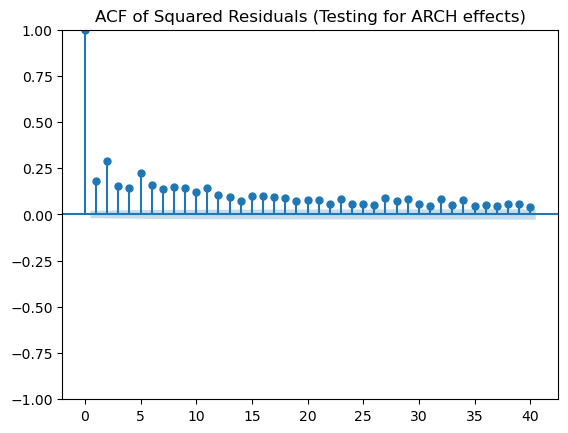

In [5]:
arch_test = sd.het_arch(resid, nlags=12)

# Output: (LM stat, p-value, F stat, p-value)
print(f"ARCH Test Results:")
print(f"LM Statistic: {arch_test[0]:.4f}, p-value: {arch_test[1]:.4f}")
print(f"F-Statistic: {arch_test[2]:.4f}, p-value: {arch_test[3]:.4f}")

plot_acf(resid**2, lags=40)
plt.title("ACF of Squared Residuals (Testing for ARCH effects)")
plt.show()


## Estimating Volatility Dynamics

To capture the changing uncertainty in financial markets, we estimate volatility using a variety of GARCH-type models:

- **GARCH (1,1)**: Captures persistence and clustering in volatility.
- **EGARCH**: Models asymmetry in volatility, where negative returns might have stronger impact.
- **TGARCH**: Captures leverage effects where negative shocks increase volatility more than positive ones.

The models are estimated using daily log returns for the S&P 500 and Russell 2000 indices. Conditional volatilities are annualized and plotted to visualize how market uncertainty evolves over time.

Model performance is evaluated through:
- **Mean Squared Error (MSE)** for forecast accuracy.
- **Likelihood Ratio Tests** for comparing nested models.
- Visual inspection of residuals and volatility fit.

In [6]:
def fit_best_volatility_model(resid, model_type: str, symmetry: int):
    p_range = range(1, 5)
    q_range = range(1, 5)
    results = []

    for p in p_range:
        for q in q_range:
            try:
                model = arch_model(resid, vol=model_type, p=p, o=symmetry, q=q, dist='normal', rescale=False)
                fitted_model = model.fit(disp="off")
                results.append({
                    'p': p, 'q': q,
                    'model': model,
                    'fit': fitted_model,
                    'aic': fitted_model.aic,
                    'bic': fitted_model.bic
                })
            except Exception as e:
                print(f"Model {model_type}({p},{q}) failed: {e}")

    if not results:
        raise ValueError("No valid models were fitted.")

    best_fit = min(results, key=lambda x: x['aic'])
    return best_fit['fit']


Annualized Conditional Volatility: GARCH, EGARCH, TGARCH

In [7]:
def get_annualized_volatility(index: pd.DataFrame, model_type: str, symmetry: int):
    model = sm.ARIMA(index['Return'], order=(1, 0, 1)).fit()
    resid = model.resid

    fitted = fit_best_volatility_model(resid, model_type, symmetry)
    annual_vol = fitted.conditional_volatility * np.sqrt(252)

    mod = "TGARCH" if model_type == "GARCH" and symmetry == 1 else model_type
    return mod, index['Date'], annual_vol

Plotting Annualized Volatility

In [8]:
def plot_combined_volatilities(index: pd.DataFrame, index_name: str, smooth=False):
    models = [
        ("GARCH", 0, 'blue', '-', 'GARCH'),
        ("EGARCH", 0, 'orange', '-', 'EGARCH'),
        ("GARCH", 1, 'green', '-', 'TGARCH')
    ]

    plt.figure(figsize=(14, 6))
    for model_type, symmetry, color, style, label in models:
        label, dates, vol = get_annualized_volatility(index, model_type, symmetry)
        if smooth:
            vol = vol.rolling(window=10).mean()
        plt.plot(dates, vol, label=label, color=color, linestyle=style, alpha=0.8)

    plt.title(f'Annualized Conditional Volatility - {index_name}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()


c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-pa

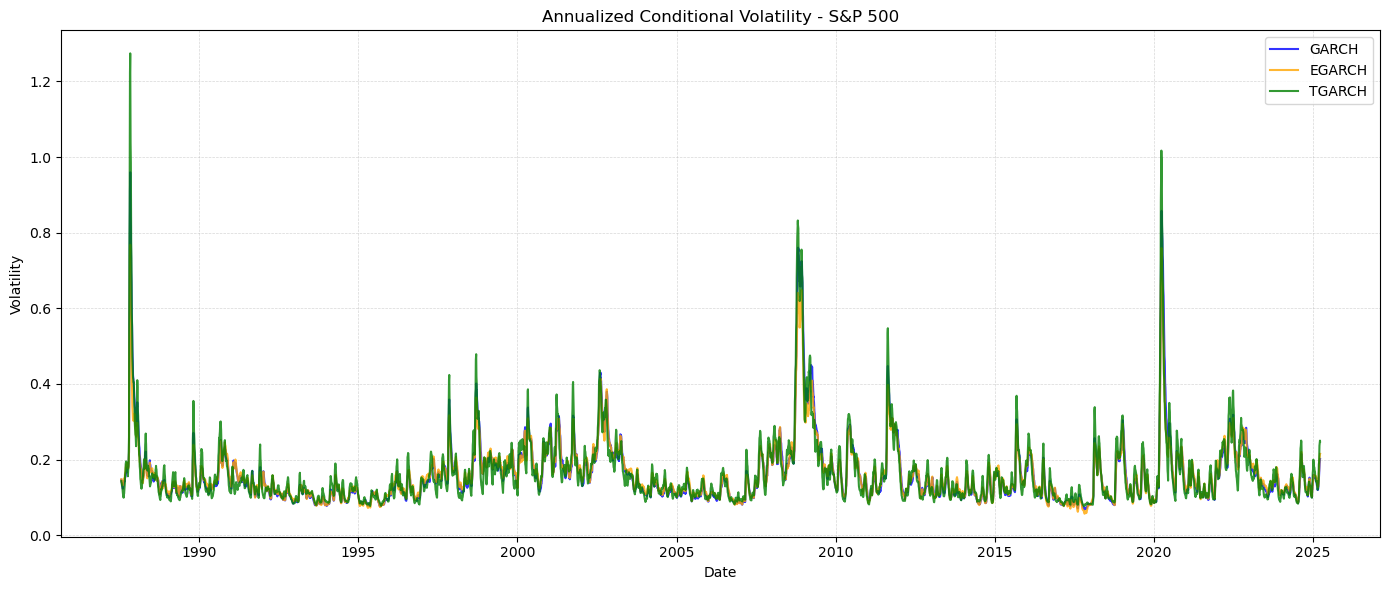

c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-pa

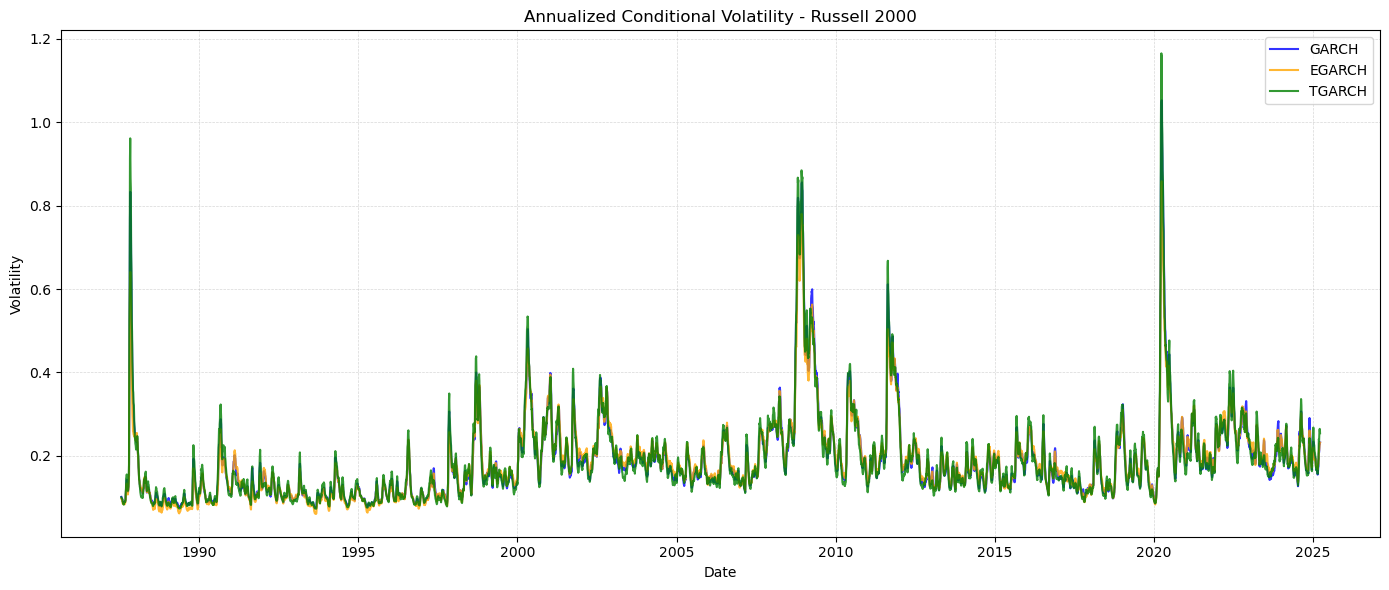

In [9]:
plot_combined_volatilities(spx, "S&P 500", smooth=True)
plot_combined_volatilities(rut, "Russell 2000", smooth=True)

Performance Evaluation: Mean Squared Error

In [10]:
indices = {'SPX': spx, 'RUT': rut}
models = [('GARCH', 0), ('EGARCH', 0), ('GARCH', 1)]
mse_results = []

for index_name, index_data in indices.items():
    actual_vol = index_data['Return'].rolling(window=30).std() * np.sqrt(252)
    for model_type, symmetry in models:
        try:
            _, _, predicted_vol = get_annualized_volatility(index_data, model_type, symmetry)

            df = pd.DataFrame({'actual': actual_vol, 'predicted': predicted_vol}).dropna()
            mse = mean_squared_error(df['actual'], df['predicted'])

            model_label = 'TGARCH' if model_type == 'GARCH' and symmetry == 1 else model_type
            mse_results.append({'Index': index_name, 'Model': model_label, 'MSE': mse})
        except Exception as e:
            continue

mse_df = pd.DataFrame(mse_results)
mse_df = mse_df.pivot(index='Model', columns='Index', values='MSE').round(6)
print(mse_df)

c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-pa

Index        RUT       SPX
Model                     
EGARCH  0.001643  0.001602
GARCH   0.001435  0.000986
TGARCH  0.002433  0.002946


c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Performance Evaluation: Likelihood Ratio Test (LR Test)

In [11]:
resid = sm.ARIMA(spx['Return'], order=(1, 0, 1)).fit().resid

def lr_test(model1: str, model2: str, symmetry1=0, symmetry2=0):
    model1_fit = fit_best_volatility_model(resid, model1, symmetry1)
    model2_fit = fit_best_volatility_model(resid, model2, symmetry2)
    model1 = "TGARCH" if model1 == "GARCH" and symmetry1 == 1 else model1
    model2 = "TGARCH" if model2 == "GARCH" and symmetry2 == 1 else model2

    if model2_fit.num_params - model1_fit.num_params == 0:
        print(f"LR-test between {model1} and {model2} not applicable because df = 0")
        return
    elif model2_fit.num_params - model1_fit.num_params > 0:
        model1, model2 = model2, model1
        model1_fit, model2_fit = model2_fit, model1_fit
    
    lr_stat = 2 * (model1_fit.loglikelihood - model2_fit.loglikelihood)
    df = model1_fit.num_params - model2_fit.num_params
    p_value = 1 - chi2.cdf(lr_stat, df)
    if p_value < 0.05:
        print(f"H0 rejected: {model1} fits significantly better than {model2} (LR Stat: {lr_stat:.4f}, df: {df}, p-value: {p_value:.4f})")
    else:
        print(f"H0 not rejected: {model1} not significantly better than {model2} (LR Stat: {lr_stat:.4f}, df: {df}, p-value: {p_value:.4f})")


lr_test("GARCH", "EGARCH")
lr_test("GARCH", "GARCH", 0, 1)
lr_test("EGARCH", "GARCH", 0, 1)

c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-pa

H0 rejected: GARCH fits significantly better than EGARCH (LR Stat: 10.9696, df: 2, p-value: 0.0041)


c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-pa

LR-test between GARCH and TGARCH not applicable because df = 0


c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-pa

H0 rejected: TGARCH fits significantly better than EGARCH (LR Stat: 281.8970, df: 2, p-value: 0.0000)


### **Time-varying Correlation**

Rolling Window Correlation

In [12]:
def rolling_correlation(df1, df2):
    windows = [30, 90, 180]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    plt.figure(figsize=(14, 6))

    for w, c in zip(windows, colors):
        rolling = df1['Return'].rolling(window=w).corr(df2['Return'])
        plt.plot(df1['Date'], rolling, label=f'{w}-Day Window', color=c, linestyle="-", linewidth=2)

    plt.title('Rolling Window Correlation (SPX vs RUT)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title='Window Size')
    plt.tight_layout()
    plt.show()

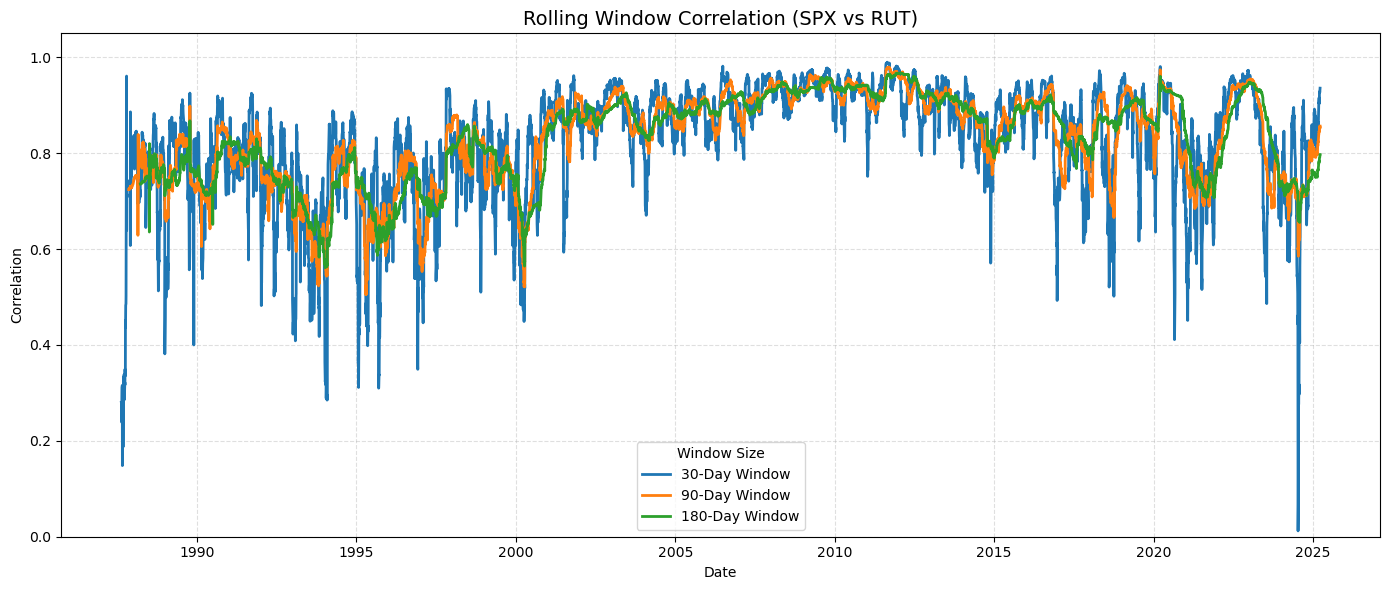

In [13]:
rolling_correlation(spx, rut)

EWMA (Exponentially Weighted Moving Average)

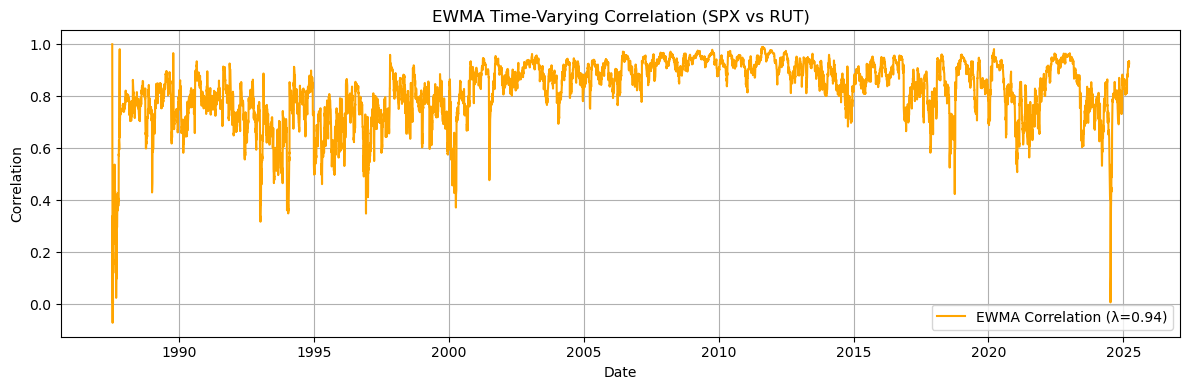

In [14]:
def ewma_cov_corr(df1, df2, lambda_=0.94):
    r1 = df1['Return']
    r2 = df2['Return']
    cov = (r1 * r2).ewm(alpha=1 - lambda_).mean()
    var1 = (r1 ** 2).ewm(alpha=1 - lambda_).mean()
    var2 = (r2 ** 2).ewm(alpha=1 - lambda_).mean()
    corr = cov / np.sqrt(var1 * var2)
    return corr

spx['EWMACorr'] = ewma_cov_corr(spx, rut)

plt.figure(figsize=(12, 4))
plt.plot(spx['Date'], spx['EWMACorr'], label='EWMA Correlation (λ=0.94)', color='orange')
plt.title('EWMA Time-Varying Correlation (SPX vs RUT)')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

DCC-GARCH

            Close_SPX  Return_SPX  EWMACorr  Close_RUT  Return_RUT
Date                                                              
1987-07-10     308.37    0.002764  1.000000     166.22    0.001929
1987-07-13     307.63   -0.002400  0.357078     166.38    0.000963
1987-07-14     310.68    0.009915  0.034946     166.35   -0.000180
1987-07-15     310.42   -0.000837 -0.070350     167.61    0.007574
1987-07-16     312.70    0.007345  0.137048     168.04    0.002565
1987-07-17     314.59    0.006044  0.341706     168.85    0.004820
1987-07-20     311.39   -0.010172  0.005047     169.49    0.003790
1987-07-21     308.55   -0.009120  0.199367     168.81   -0.004012
1987-07-22     308.47   -0.000259  0.160269     167.37   -0.008530
1987-07-23     307.81   -0.002140  0.173305     167.10   -0.001613


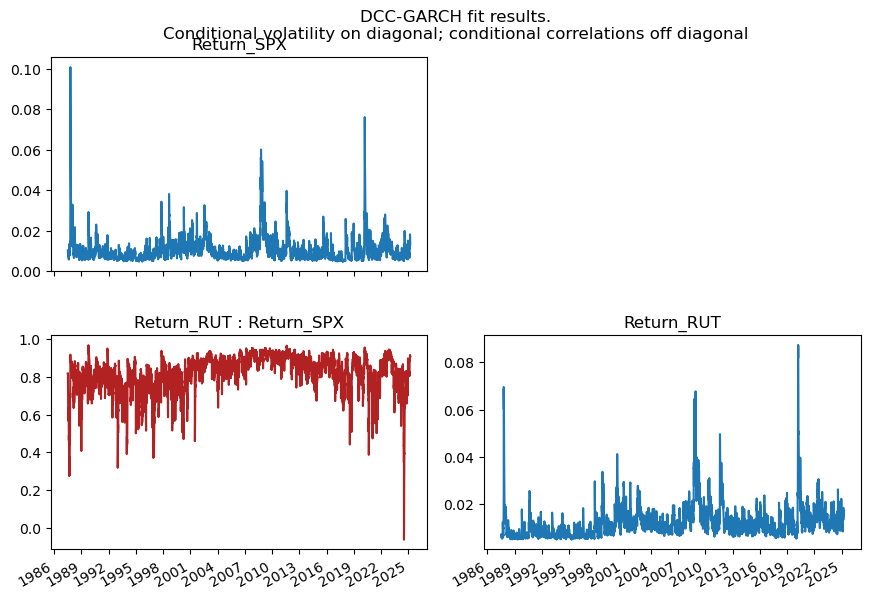

array([[<Axes: title={'center': 'Return_SPX'}>, <Axes: >],
       [<Axes: title={'center': 'Return_RUT : Return_SPX'}>,
        <Axes: title={'center': 'Return_RUT'}>]], dtype=object)

In [22]:
#The general framework is from https://github.com/jack-tobin/mvgarch because there is no standard framework for Multivariate GARCH

combined_data = pd.merge(spx, rut, on="Date", suffixes=('_SPX', '_RUT')).dropna()
combined_data.set_index("Date", inplace=True)
garch = UGARCH(order=(1, 1))
garch.spec(returns=spx["Return"])
garch.fit()

garch_specs = [UGARCH(order=(1, 1)), UGARCH(order=(1, 1))]
dcc = DCCGARCH()
dcc.spec(ugarch_objs=garch_specs, returns=combined_data[["Return_SPX", "Return_RUT"]])
dcc.fit()
dcc.plot()

### **Lead-lag Relationships**

Vector Autoregression (VAR)

In [47]:
def garch_model(index: pd.DataFrame):
    model = sm.ARIMA(index['Return'], order=(1, 0, 1)).fit()
    resid = model.resid

    p_range = range(1, 5)
    q_range = range(1, 5)
    results = []
    
    for p in p_range:
        for q in q_range:
            try:
                model = arch_model(resid, vol="GARCH", p=p, q=q, dist='normal', rescale=False)
                fitted_model = model.fit(disp='off')
                results.append({'p': p, 'q': q, 'AIC': fitted_model.aic, 'BIC': fitted_model.bic})
            except Exception as e:
                continue

    results_df = pd.DataFrame(results)
    results_df.sort_values(by='AIC', inplace=True)
    best_model_params = results_df.iloc[0]

    best_model = arch_model(resid, vol="GARCH", p=int(best_model_params['p']), q=int(best_model_params['q']), dist='normal', rescale=False)
    return best_model.fit(disp='off')

spx_vol = garch_model(spx).conditional_volatility
rut_vol = garch_model(rut).conditional_volatility

vol_data = pd.DataFrame({'SPX_vol': np.log(spx_vol * np.sqrt(252)), 'RUT_vol': np.log(rut_vol * np.sqrt(252))}).dropna()

model = VAR(vol_data)
results = model.fit(maxlags=20, ic='aic')

print(results.summary())

c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\romen\anaconda3\Lib\site-pa

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 02, Apr, 2025
Time:                     19:54:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.2076
Nobs:                     9479.00    HQIC:                  -11.2465
Log likelihood:           26575.3    FPE:                1.27946e-05
AIC:                     -11.2665    Det(Omega_mle):     1.26899e-05
--------------------------------------------------------------------
Results for equation SPX_vol
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.030441         0.004024           -7.564           0.000
L1.SPX_vol          1.116196         0.015412           72.424           0.000
L1.RUT_vol          0.061446         0.016469            3.731    

Performance Evaluation: R Squared (VAR Model)

In [48]:
def var_r_squared(var_results):
    r_squared = {}
    k_ar = var_results.k_ar 
    endog = var_results.model.endog
    for i, endog_name in enumerate(var_results.model.endog_names):
        actual = endog[k_ar:, i]
        fitted = var_results.fittedvalues.iloc[:, i].values
        ss_res = np.sum((actual - fitted) ** 2)
        ss_tot = np.sum((actual - np.mean(actual)) ** 2)
        r_squared[endog_name] = 1 - (ss_res/ss_tot)
    return r_squared

r2_dict = var_r_squared(results)
print("R-squared values per equation:")
for var, r2 in r2_dict.items():
    print(f"{var}: {r2:.4f}")

R-squared values per equation:
SPX_vol: 0.9658
RUT_vol: 0.9738


Granger Causality Tests

In [49]:
# Test if SPX_vol Granger-causes RUT_vol
granger_test_spx = results.test_causality('RUT_vol', ['SPX_vol'], kind='f')
print(granger_test_spx.summary())

# Test if RUT_vol Granger-causes SPX_vol
granger_test_rut = results.test_causality('SPX_vol', ['RUT_vol'], kind='f')
print(granger_test_rut.summary())

Granger causality F-test. H_0: SPX_vol does not Granger-cause RUT_vol. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value      df    
-------------------------------------------------
         1.579          1.587   0.052 (19, 18880)
-------------------------------------------------
Granger causality F-test. H_0: RUT_vol does not Granger-cause SPX_vol. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value      df    
-------------------------------------------------
         2.427          1.587   0.000 (19, 18880)
-------------------------------------------------


Impulse Response

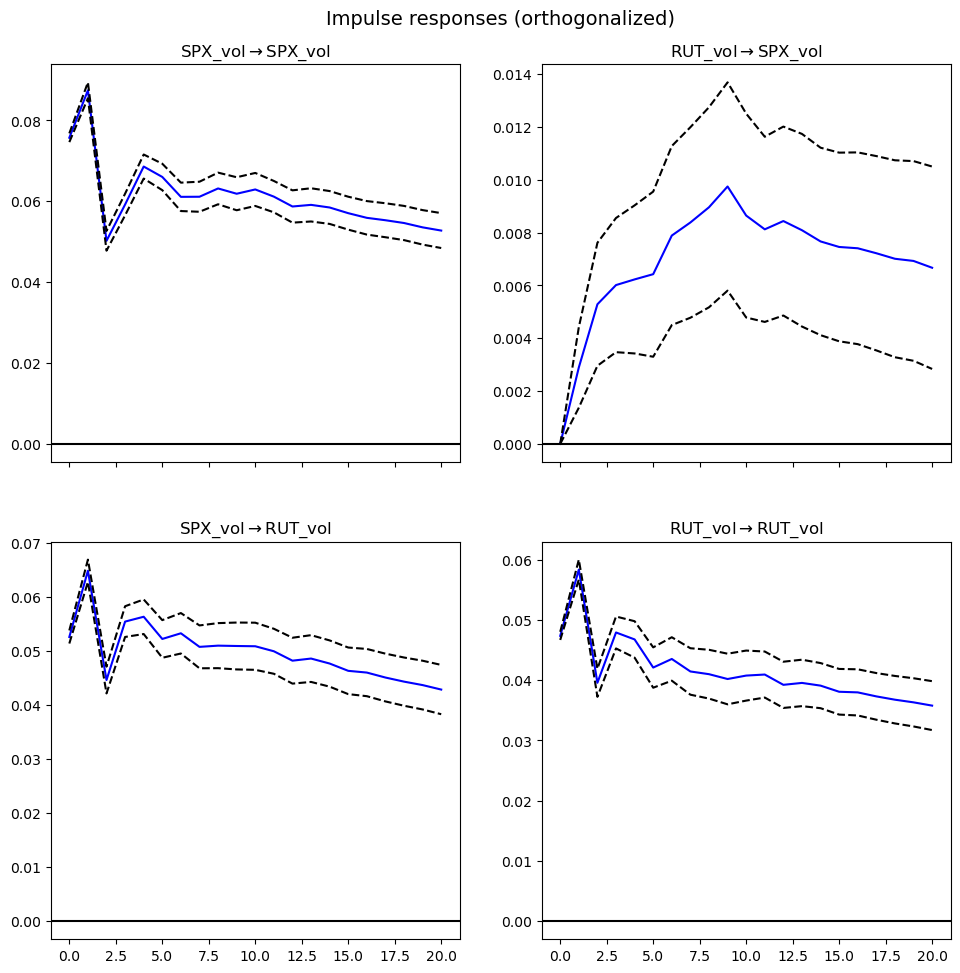

In [39]:
irf = results.irf(20)
irf.plot(orth=True)
plt.show()